# Search Log Viewer
Parse and visualize the logs from the search base class

In [291]:
import os
import sys
from pathlib import Path
import json
import math
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np

# Default plot size
plt.rcParams["figure.figsize"] = [30,15]

In [56]:
def add_thumbnail(ax, file, x, y):
    image = plt.imread(str(file))
    # Check if the RED (0 index) channel is white (1.0)
    bg_mask = image[:,:,0] == 1.0
    # Then set the ALPHA channel to 0
    image[bg_mask, 3] = 0
    offset_image = OffsetImage(image, zoom=0.4)
    ab = AnnotationBbox(offset_image, (x, y), frameon=False)
    ax.add_artist(ab)

def plot_rollout(log_file):
    with open(log_file, "r", encoding="utf8") as f:
        log_data = json.load(f)
    current_iou = 0
    prev_iou = 0
    valid_step = []
    valid_iou = []
    invalid_step = []
    invalid_iou = []
    all_step = []
    max_iou = []
    rollout_lines = []
    prev_rollout_attempt = 0
    thumbnails = []
    for action in log_data:
        rollout_attempt = action["rollout_attempt"]
        if rollout_attempt != prev_rollout_attempt:
            current_iou = 0
        step = action["used_budget"]
        iou = action["current_iou"]
        all_step.append(step)
        max_iou.append(action["max_iou"])
        if iou is None:
            invalid_step.append(step)
            invalid_iou.append(current_iou)
        else:
            valid_step.append(step)
            valid_iou.append(iou)
            current_iou = iou
        if rollout_attempt != prev_rollout_attempt:
            prev_rollout_attempt = rollout_attempt
            rollout_lines.append(step)
        iou_delta = math.fabs(prev_iou - current_iou)
        if "screenshot" in action and iou is not None and iou_delta > 0.15:
            thumbnails.append({
                "x": step - 0.5,
                "y": current_iou,
                "file": log_file.parent / action["screenshot"]
            })
        prev_iou = current_iou
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.set_ylim([-0.05, 1.05])
    # Rollout lines
    for line in rollout_lines:
        plt.axvline(x=line, color='silver')
    for thumbnail in thumbnails:
        add_thumbnail(ax, thumbnail["file"], thumbnail["x"], thumbnail["y"])
    ax.scatter(invalid_step, invalid_iou, 75, color='r')
    ax.scatter(valid_step, valid_iou, 75, color='b')
    ax.plot(all_step, max_iou)
    ax.set_xlabel('Step')
    ax.set_ylabel('IoU')
    ax.set_title(f"{log_file.stem}")
    plt.show()


def plot_perfect_reconstructions(perfect_reconstructions):
    (unique, counts) = np.unique(perfect_reconstructions, return_counts=True)
    fig, ax = plt.subplots()
    ax.bar(unique[1:], counts[1:])
    ax.set_xlabel('Steps')
    ax.set_ylabel('#Perfect Reconstructions')
    ax.set_title("Perfect Reconstructions")
    plt.show()
    
    
def plot_iou_over_time(iou_over_time, title):
    fig, ax = plt.subplots()
    ax.set_ylim([-0.05, 1.05])
    ax.plot(range(1, len(iou_over_time) + 1), iou_over_time, linewidth=4)
    ax.set_xlabel('Step')
    ax.set_ylabel('Max IoU')
    ax.set_title(title)
    plt.show()
    
def plot_average_probabilities(log_file):
    with open(log_file, "r", encoding="utf8") as f:
        log_data = json.load(f)
    probabilities = []
    for action in log_data:
        probabilities.append(action["probabilities"])
    probs_mean = np.mean(probabilities, axis=0)
    fig, ax = plt.subplots()
#     for prob in probabilities:
#         ax.plot(range(0, len(prob)), prob, linewidth=1)
    ax.plot(range(0, len(probs_mean)), probs_mean, linewidth=4)
    ax.set_title(f"{log_file.stem} Action Probability Curve")
    plt.show()
    
def evaluate_log_file(log_file, budget):
    """Evaluate a single log file"""
    with open(log_file, "r", encoding="utf8") as f:
        log_data = json.load(f)
    max_ious = []
    perfect_reconstruction = 0
    best_rollout_attempt = -1
    current_iou = 0
    used_budget = 0
    
    for action in log_data:
        # Limit to the budget length
        if action["used_budget"] < budget:
            used_budget = action["used_budget"]
            if action["max_iou"] > current_iou:
                current_iou = action["max_iou"]
                best_rollout_attempt = action["rollout_attempt"]
            max_ious.append(action["max_iou"])
            if perfect_reconstruction == 0:
                if math.isclose(action["max_iou"], 1, abs_tol=0.00001):
                    perfect_reconstruction = action["used_budget"] + 1

    # Loop over again to count the rollout steps taken
    current_iou = 0
    best_rollout_length = 0
    for action in log_data:
        if action["rollout_attempt"] == best_rollout_attempt:
            if action["max_iou"] > current_iou:
                best_rollout_length += 1
   
    time_taken = log_data[-1]["time"] - log_data[0]["time"]        
    return np.array(max_ious), time_taken, perfect_reconstruction, best_rollout_length, used_budget


def get_design_extrude_count(file):
    """Get the number of extrude steps in a design"""
    with open(file, encoding="utf8") as f:
        json_data = json.load(f)
    timeline = json_data["timeline"]
    entities = json_data["entities"]
    extrude_count = 0
    for timeline_object in timeline:
        entity_uuid = timeline_object["entity"]
        entity_index = timeline_object["index"]
        entity = entities[entity_uuid]
        if entity["type"] == "ExtrudeFeature":
            extrude_count += 1
    return extrude_count

def get_budget(log_file):
    """Get the budget from a log file"""
    with open(log_file, "r", encoding="utf8") as f:
        log_data = json.load(f)
    return log_data[0]["budget"]


def set_array_length(array, length):
    if len(array) > length:
        return array[0:length]
    elif len(array) < length:
        last_value = array[-1]
        num_to_add = length - len(array)
        values_to_add = np.full(num_to_add, last_value)
        return np.append(array, values_to_add)
    else:
        return array

    
def evaluate(log_dir, dataset_dir):
    """Evaluate an experiments logs"""
    log_files = [f for f in log_dir.glob("**/*_log.json")]
    result = {}
    results_file = log_dir / "search_results.json"
    assert results_file.exists()
    with open(results_file, "r", encoding="utf8") as f:
        results_data = json.load(f)
    result["files_processed"] = len(results_data)
    result_status = {}
    for file, result_data in results_data.items():
        status = result_data["status"]
        if status not in result_status:
            result_status[status] = 0
        result_status[status] += 1
        log_file = log_dir / f"{file}/{file}_log.json"
        if not log_file.exists():
            print(f"File {file} does not exist! ({status})")
            
        
    result["files_success"] = result_status["Success"]
    if "Crash" in result_status:
        result["files_crash"] = result_status["Crash"]
    else:
        result["files_crash"] = 0
    if "Timeout" in result_status:
        result["files_timeout"] = result_status["Timeout"]
    else:
        result["files_timeout"] = 0
    if "Fail" in result_status:
        result["files_fail"] = result_status["Fail"]
    else:
        result["files_fail"] = 0
    
    log_file_count_estimate = result["files_success"] + result["files_crash"] + result["files_timeout"]
    log_file_count_actual = len(log_files)
    if log_file_count_actual != log_file_count_estimate:
        print(f"Log file count ({log_file_count_actual}) does not match count of files successfully processed ({log_file_count_estimate})")

    budget = get_budget(log_files[0])
    budgets_used = []
    times_taken = []
    max_iou = []
    max_iou_over_time = np.zeros(shape=(log_file_count_actual, budget))
    perfect_reconstructions = []
    sequence_deltas = []
    sequence_deltas_perfect = []
    
    for index, log_file in enumerate(log_files):
        max_ious_raw, time_taken, perfect_reconstruction, best_rollout_length, used_budget = evaluate_log_file(log_file, budget)
       
        dataset_json_file = dataset_dir / f"{log_file.parent.stem}.json"
        extrude_count = get_design_extrude_count(dataset_json_file)
        sequence_delta = abs(best_rollout_length - extrude_count)
        sequence_deltas.append(sequence_delta)
        if perfect_reconstruction > 1:
            sequence_deltas_perfect.append(sequence_delta)
        
        times_taken.append(time_taken)
        budgets_used.append(used_budget)
        max_ious = set_array_length(max_ious_raw, budget)
        assert len(max_ious) == budget
        max_iou_max = np.max(max_ious)
        perfect_reconstructions.append(perfect_reconstruction)           
        max_iou.append(max_iou_max)
        max_iou_over_time[index] = max_ious
    
    result["time_taken_mean"] = np.mean(times_taken)
    result["budget_used_mean"] = np.mean(budgets_used)
    result["sequence_delta_mean"] = np.mean(sequence_deltas)
    result["sequence_delta_perfect_mean"] = np.mean(sequence_deltas_perfect)
    result["perfect_reconstruction"] = np.count_nonzero(perfect_reconstructions)
    result["perfect_reconstructions"] = np.array(perfect_reconstructions)
    result["perfect_reconstruction_percent"] = result["perfect_reconstruction"] / log_file_count_actual
    result["max_iou_mean"] = np.mean(max_iou)
    result["max_iou_over_time"] = max_iou_over_time
 
    return result

## Create a rollout plot from a single log

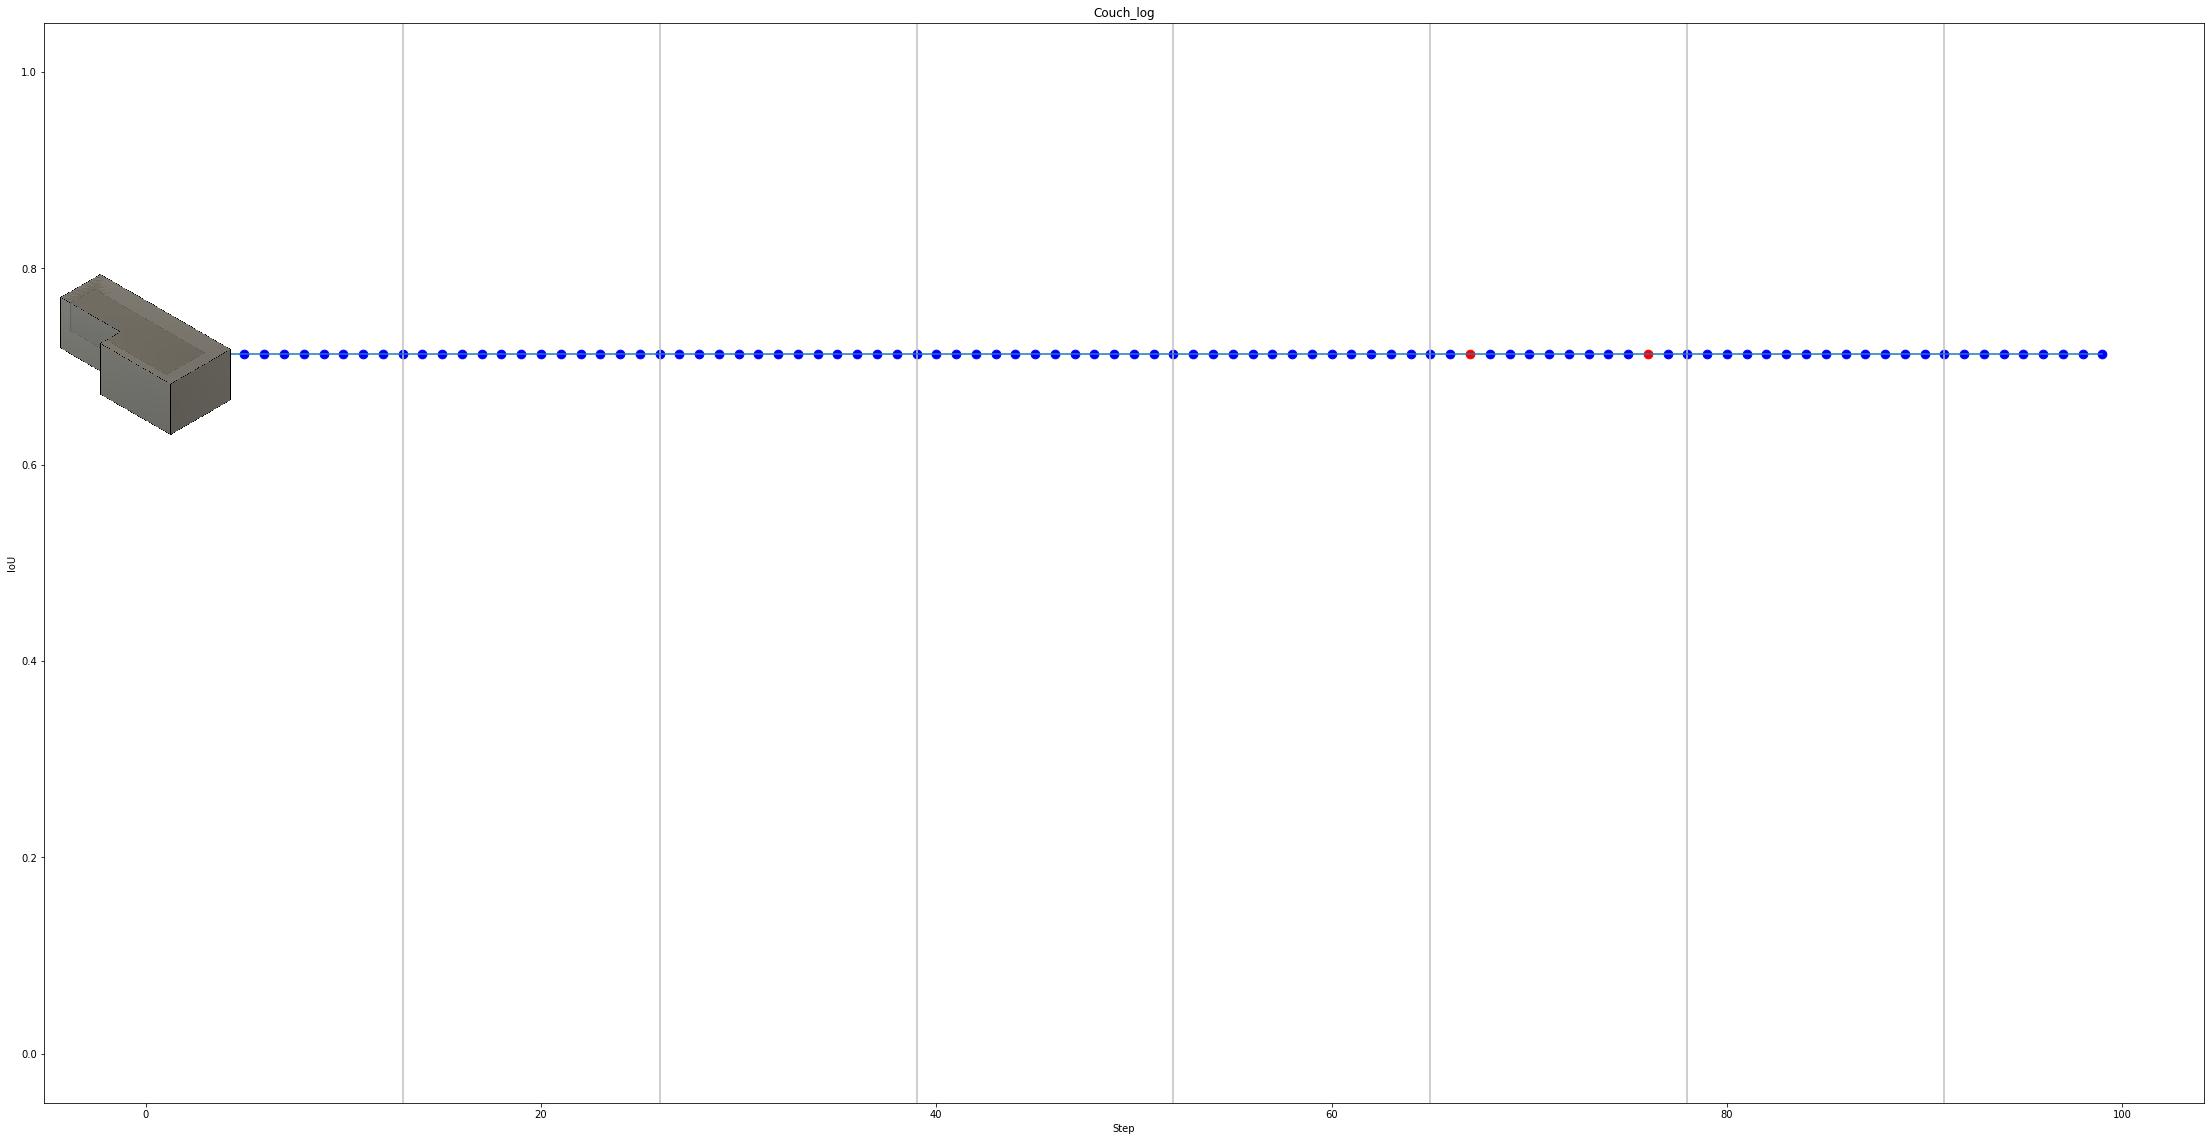

In [296]:
log_file = Path("Couch/Couch_log.json")
plot_rollout(log_file)

## Action Probability Curve

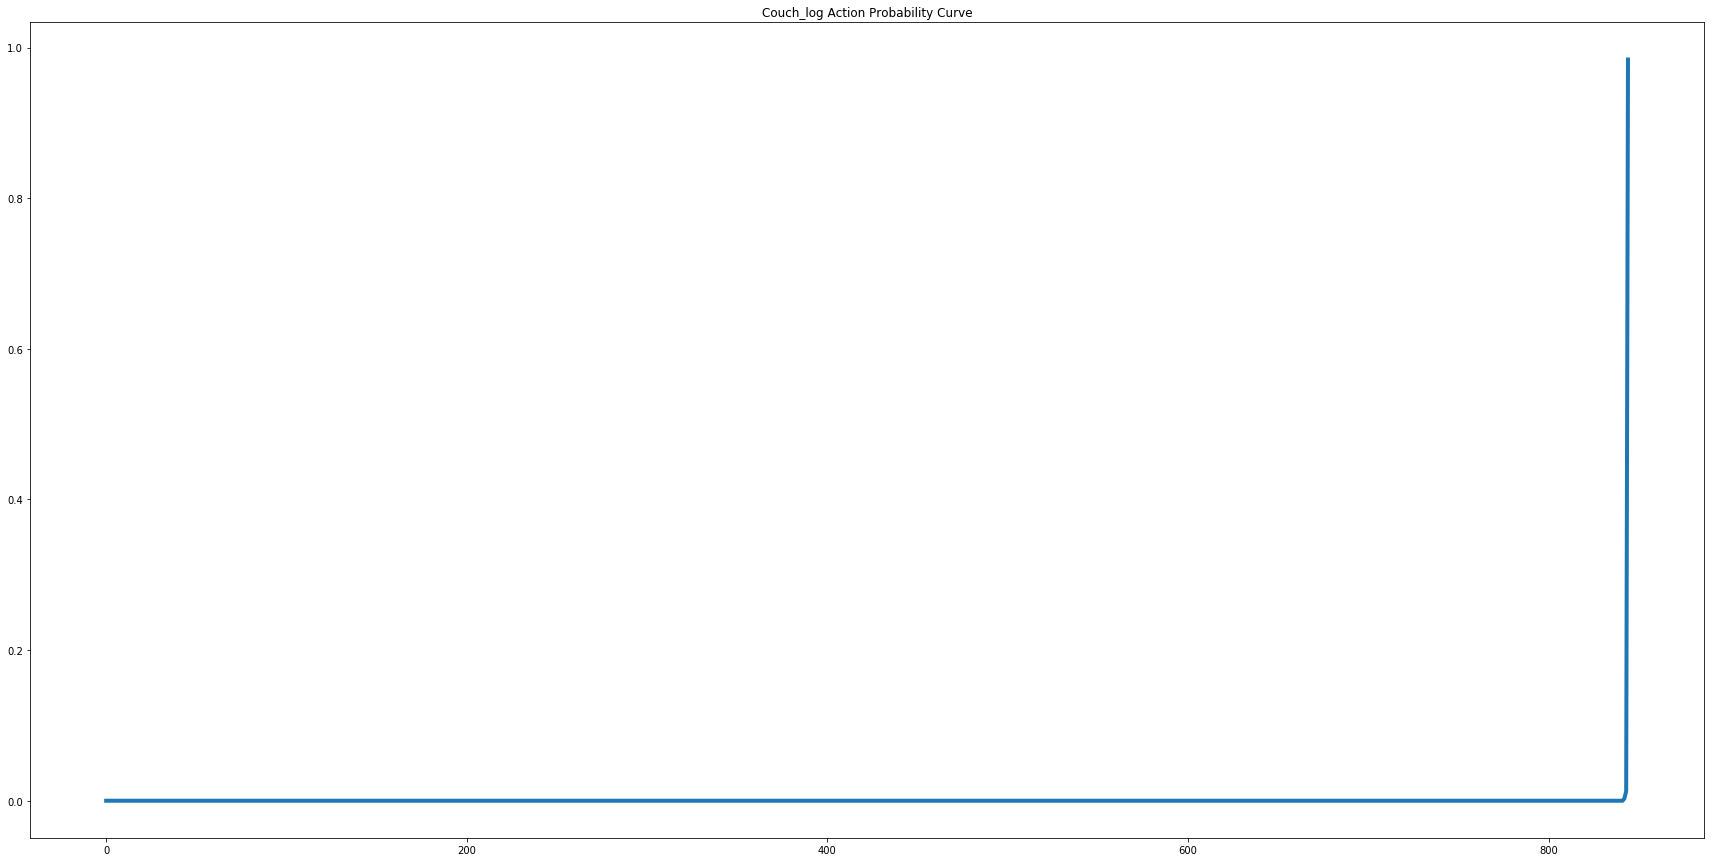

In [306]:
plot_average_probabilities(log_file)

## Plot the reconstruction performance over time

In [61]:
# Evaluate a full search experiment
log_dir = Path("C:/Users/Administrator/Autodesk/results/d7/super_rand_02")
dataset_dir = Path("C:/Users/Administrator/Autodesk/data/d7/d7")
result = evaluate(log_dir, dataset_dir)
result

File 98853_8019a7b7_0000 does not exist! (Fail)
File 91424_9c24fe70_0000 does not exist! (Fail)
File 83374_f47c70a0_0000 does not exist! (Fail)
Log file count (64) does not match count of files successfully processed (63)


{'files_processed': 66,
 'files_success': 63,
 'files_crash': 0,
 'files_timeout': 0,
 'files_fail': 3,
 'time_taken_mean': 35.233275804668665,
 'budget_used_mean': 48.6875,
 'sequence_delta_mean': 5.796875,
 'sequence_delta_perfect_mean': 5.4,
 'perfect_reconstruction': 33,
 'perfect_reconstructions': array([ 0,  1,  2,  1,  0,  0,  1,  0, 24,  1,  0,  0,  0,  1,  1,  0, 25,
         1,  1,  0,  1,  1,  1,  1,  0,  1,  0,  0,  0,  3,  1,  1,  1,  1,
         0,  0,  0,  1,  0,  0,  1,  0,  0,  0,  1,  0,  0,  0,  0,  0,  1,
         0, 30,  0,  1,  1,  1,  0,  1,  0,  1,  1,  1,  0]),
 'perfect_reconstruction_percent': 0.515625,
 'max_iou_mean': 0.807561902368386,
 'max_iou_over_time': array([[0.04748309, 0.04750105, 0.04752021, ..., 0.04757672, 0.04757672,
         0.04757672],
        [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
         1.        ],
        [0.9996131 , 1.        , 1.        , ..., 1.        , 1.        ,
         1.        ],
        ...,
    

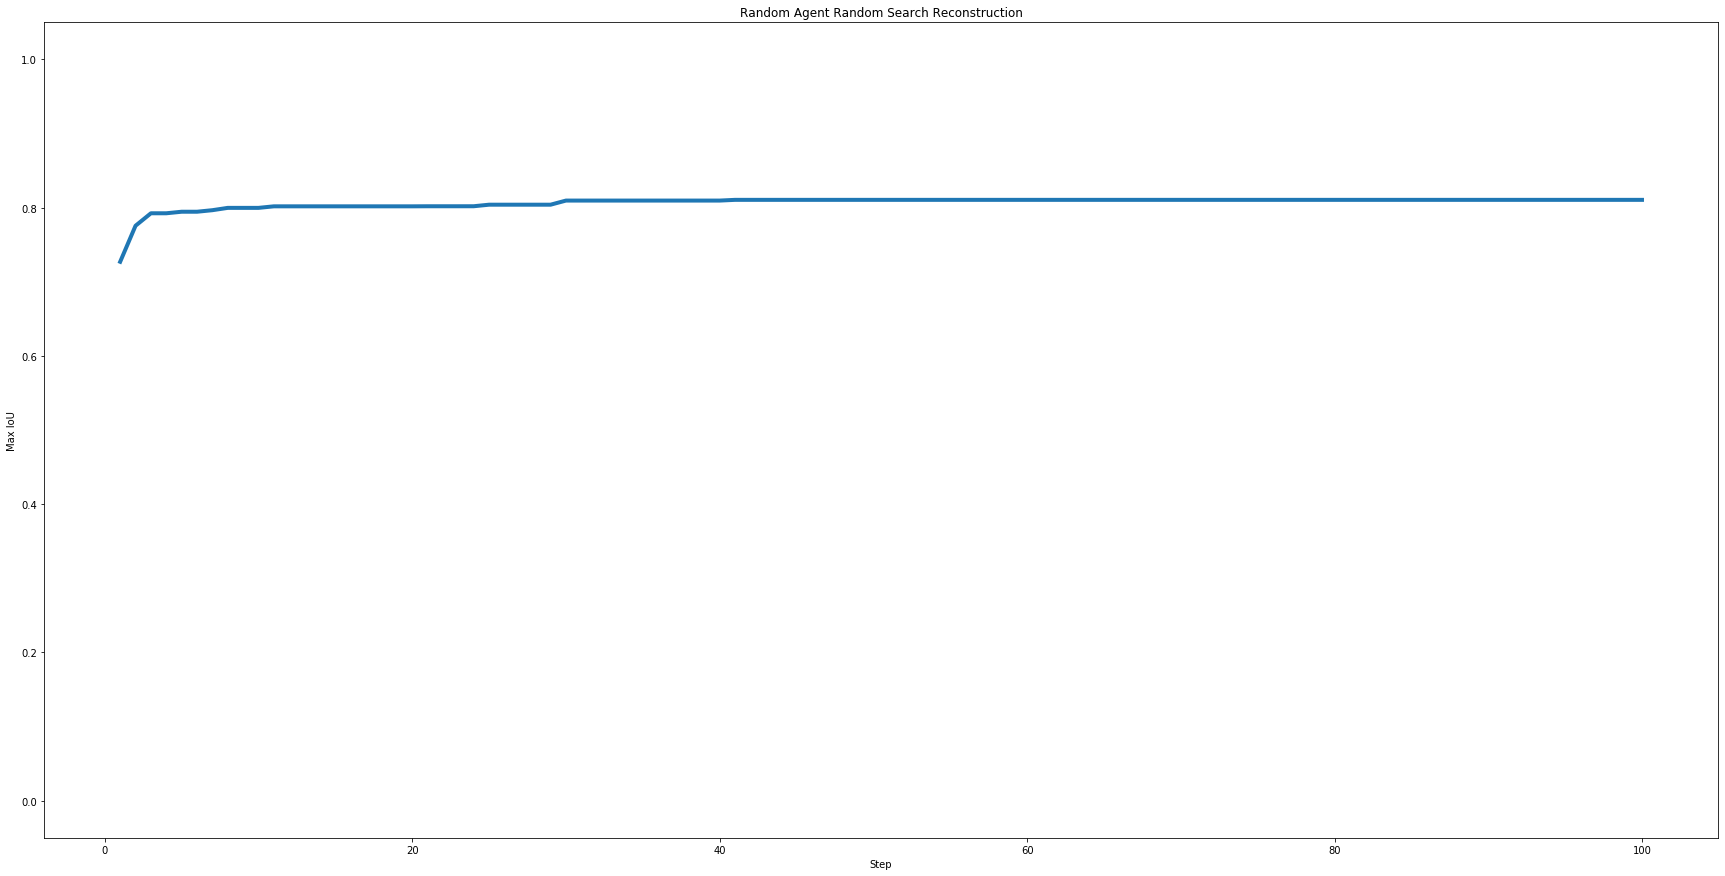

In [58]:
max_iou_mean_over_time = np.mean(result["max_iou_over_time"], axis=0)
plot_iou_over_time(max_iou_mean_over_time, "Random Agent Random Search Reconstruction")

## Show the distribution of perfect reconstructions

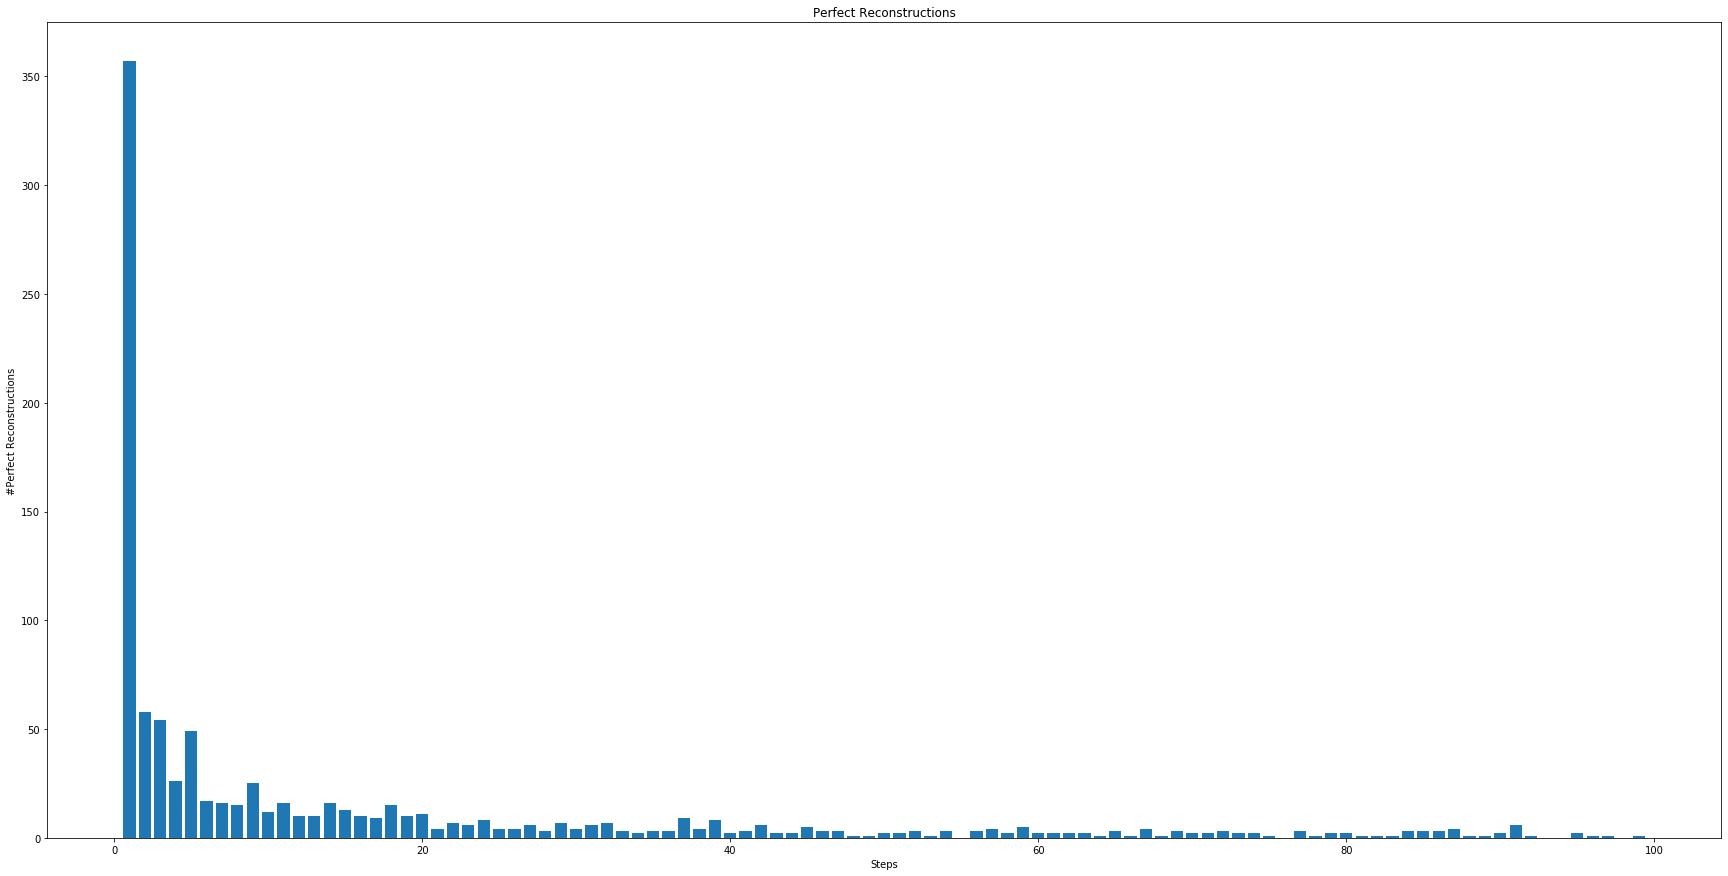

In [286]:
plot_perfect_reconstructions(result["perfect_reconstructions"])